Importing Packages

In [1]:
import numpy as np 
import pandas as pd
import xgboost as xgb

C:\Users\user\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
np.random.seed(0)

In [3]:
application_train = pd.read_csv('application_train.csv', delimiter=',')
display(application_train.shape)

(307511, 122)

In [4]:
application_test = pd.read_csv('application_test.csv', delimiter=',')
display(application_test.shape)

(48744, 121)

Analysing Class Imbalance

In [5]:
rejected_applications_df = application_train[(application_train['TARGET'] == 1)] # Risk detected in loan application, hence reject it.
accepted_applications_df = application_train[(application_train['TARGET'] == 0)] #No Risk

print("Rejected Applications in Trainset: ", len(rejected_applications_df))
print("Accepted Applications in Trainset: ", len(accepted_applications_df))

Rejected Applications in Trainset:  24825
Accepted Applications in Trainset:  282686


In [6]:
# Dataframe without any na values
accepted_without_na = accepted_applications_df.dropna()
accepted_without_na.shape

(8076, 122)

In [7]:
# DF with Na values 
accepted_with_na = accepted_applications_df[accepted_applications_df.isna().any(axis='columns')]
accepted_with_na.shape

(274610, 122)

In [8]:
# Take remaining rows from accepted_applications_sampled

remaining = 100000 - (len(rejected_applications_df) + len(accepted_without_na))
print(remaining)

accepted_sampled_na = accepted_with_na.sample(n = remaining+1, random_state=0)
accepted_sampled_na.shape

67099


(67100, 122)

In [9]:
# train_df[train_df["CODE_GENDER"] == "XNA"].index

In [10]:
# # drop_xna_index = train_df[train_df["CODE_GENDER"] == "XNA"].index
# drop_xna_index

In [11]:
train_df = pd.concat([rejected_applications_df, accepted_without_na, accepted_sampled_na ], ignore_index=True)

#Shuffle
train_df = train_df.sample(frac=1).reset_index(drop=True)

#Sort
train_df.sort_values(by=['SK_ID_CURR'],inplace = True,ignore_index=True)


# Dropping Extra Gender

train_df.drop(index = train_df[train_df["CODE_GENDER"] == "XNA"].index, inplace = True)

display(train_df.shape)

(100000, 122)

In [12]:
test_df = application_test.iloc[:1000,:]
test_df.shape

(1000, 121)

Feature Selection

Missing Values

In [13]:
col = application_train.columns

#List of all features containing null values
features_with_na = []

#Checking for NaN
for i in range(len(col)):
    check_for_nan = application_train[col[i]].isnull().values.any()
    if check_for_nan == True: 
        features_with_na.append(col[i])

# print("Features containing Null values: ")
# print('\n')
# print(features_with_na)
# print('\n')

#Calculating the percentage of NaN values
inconsistent_features = []
for i in features_with_na:
#     print(i) 
    percent_missing = 100*application_train[i].isnull().sum() / application_train.shape[0]
    
#     print ('Percentage of NaN: ' , round(percent_missing,2),"%")
#     print('\n')
    if percent_missing > 25:
#         print(i) 
#         print ('Percentage of NaN: ' , round(percent_missing,2),"%")
#         print('\n')
        inconsistent_features.append(i)
# print('\n')

print("Num of features with atleast 1 NaN value: ", len(features_with_na))
print("Num of features with more than 25% of missing values : ", len(inconsistent_features))

Num of features with atleast 1 NaN value:  67
Num of features with more than 25% of missing values :  50


In [14]:
inconsistent_features

['OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MO

As the relevant feature is just "OCCUPATION_TYPE" which describes the occupation of an individual, we will keep this feature and remove the rest. 

In [15]:
inconsistent_features.remove('OCCUPATION_TYPE')
inconsistent_features

train_df.drop(columns = inconsistent_features,inplace = True)
train_df.shape

(100000, 73)

In [16]:
test_df.drop(columns = inconsistent_features,inplace = True)
test_df.shape

C:\Users\user\AppData\Local\Temp\ipykernel_26640\2447900702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns = inconsistent_features,inplace = True)


(1000, 72)

Dropping Inexplanaible features

In [17]:
train_df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_C

In [18]:
inexplanaible_features = ['EXT_SOURCE_2', "EXT_SOURCE_3",'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

In [19]:
# inexplanaible_features = ['EXT_SOURCE_2', "EXT_SOURCE_3"]

train_df.drop(columns = inexplanaible_features,inplace = True)
display(train_df.shape)
test_df.drop(columns = inexplanaible_features,inplace = True)
display(test_df.shape)

(100000, 51)

C:\Users\user\AppData\Local\Temp\ipykernel_26640\592005242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns = inexplanaible_features,inplace = True)


(1000, 50)

Converting Days Features

In [20]:
train_df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_S

In [21]:
train_df["DAYS_BIRTH"] = round(train_df["DAYS_BIRTH"]/-365)
train_df["DAYS_EMPLOYED"] = round(train_df["DAYS_EMPLOYED"]/-365)
train_df["DAYS_REGISTRATION"] = round(train_df["DAYS_REGISTRATION"]/-365)
train_df["DAYS_ID_PUBLISH"] = round(train_df["DAYS_ID_PUBLISH"]/-365)
train_df["DAYS_LAST_PHONE_CHANGE"] = round(train_df["DAYS_LAST_PHONE_CHANGE"]/-365)

test_df["DAYS_BIRTH"] = round(test_df["DAYS_BIRTH"]/-365)
test_df["DAYS_EMPLOYED"] = round(test_df["DAYS_EMPLOYED"]/-365)
test_df["DAYS_REGISTRATION"] = round(test_df["DAYS_REGISTRATION"]/-365)
test_df["DAYS_ID_PUBLISH"] = round(test_df["DAYS_ID_PUBLISH"]/-365)
test_df["DAYS_LAST_PHONE_CHANGE"] = round(test_df["DAYS_LAST_PHONE_CHANGE"]/-365)

C:\Users\user\AppData\Local\Temp\ipykernel_26640\3019370736.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["DAYS_BIRTH"] = round(test_df["DAYS_BIRTH"]/-365)
C:\Users\user\AppData\Local\Temp\ipykernel_26640\3019370736.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["DAYS_EMPLOYED"] = round(test_df["DAYS_EMPLOYED"]/-365)
C:\Users\user\AppData\Local\Temp\ipykernel_26640\3019370736.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [22]:
train_df.rename(columns={'DAYS_BIRTH':'AGE','DAYS_EMPLOYED': 'YEARS_EMPLOYED',
                             'DAYS_REGISTRATION':"YEARS_REGISTRATION" , 'DAYS_ID_PUBLISH':'YEARS_ID_PUBLISH', 
                              'DAYS_LAST_PHONE_CHANGE':"YEARS_LAST_PHONE_CHANGE"}, inplace=True)

test_df.rename(columns={'DAYS_BIRTH':'AGE','DAYS_EMPLOYED': 'YEARS_EMPLOYED',
                             'DAYS_REGISTRATION':"YEARS_REGISTRATION" , 'DAYS_ID_PUBLISH':'YEARS_ID_PUBLISH', 
                              'DAYS_LAST_PHONE_CHANGE':"YEARS_LAST_PHONE_CHANGE"}, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_26640\3448512391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.rename(columns={'DAYS_BIRTH':'AGE','DAYS_EMPLOYED': 'YEARS_EMPLOYED',


In [23]:
test_df.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'AGE', 'YEARS_EMPLOYED',
       'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',

Writing to word document

In [24]:
# pip install python-docx

In [25]:
# HomeCredit_columns_description = pd.read_csv('HomeCredit_columns_description.csv', encoding = "ISO-8859-1")
# # display(HomeCredit_columns_description)

# column_description = HomeCredit_columns_description[['Row',"Description"]]
# lista = []
# for i in range(len(inconsistent_features)):
#     a = column_description[HomeCredit_columns_description["Row"] == train_df.columns[i]].values.flatten()
# #     print(a)
#     lista.append(a)

# df = pd.DataFrame(lista)
# # df

In [26]:
# # Write to word file
# import docx

# # i am not sure how you are getting your data, but you said it is a
# # pandas data frame
# # df = pd.DataFrame(data)

# # New Document
# doc = docx.Document()
# # open an existing document
# # doc = docx.Document('New Microsoft Word Document.docx')

# # add a table to the end and create a reference variable
# # extra row is so we can add the header row
# t = doc.add_table(df.shape[0]+1, df.shape[1])

# # add the header rows.
# for j in range(df.shape[-1]):
#     t.cell(0,j).text = df.columns[j]

# # add the rest of the data frame
# for i in range(df.shape[0]):
#     for j in range(df.shape[-1]):
#         t.cell(i+1,j).text = str(df.values[i,j])

# # save the doc
# doc.save('New Microsoft Word Document.docx')

DataWig

In [27]:
# !pip install datawig --user

In [28]:
# display(train_df[train_df[features_with_na[0]].isnull()])

In [29]:
# import datawig
# # dw_train, dw_test = datawig.utils.random_split(train_df)

# #Initialize a SimpleImputer model
# imputer = datawig.SimpleImputer(
#     input_columns=["TARGET"], # column(s) containing information about the column we want to impute
#     output_column= 'AMT_ANNUITY', # the column we'd like to impute values for
#     output_path = 'imputer_model' # stores model data and metrics
#     )

# #Fit an imputer model on the train data
# imputer.fit(train_df=train_df, num_epochs=50)

# #Impute missing values and return original dataframe with predictions

# imputed = imputer.predict(train_df)

In [30]:
# display(imputed[imputed['AMT_ANNUITY'].isnull()])
# imputed['AMT_ANNUITY_imputed']

KNN Imputer

In [31]:
# train_df.info()

In [32]:
# train_df_numeric = train_df.select_dtypes(include=["number"])
# train_df_numeric

In [33]:
# train_df_cat = train_df.select_dtypes(exclude=["number"])
# train_df_cat

In [34]:
# for i in train_df_cat.columns: 
#     print(i)
#     print(train_df_cat[i].unique())

In [35]:
# from sklearn.preprocessing import OrdinalEncoder
# #instantiate both packages to use
# encoder = OrdinalEncoder()


# # create a list of categorical columns to iterate over
# cat_cols = train_df_cat.columns


# def encode(data):
#     '''function to encode non-null data and replace it in the original data'''
#     #retains only non-null values
#     nonulls = np.array(data.dropna())
    
#     #reshapes the data for encoding
#     impute_reshape = nonulls.reshape(-1,1)
    
#     #encode date
#     impute_ordinal = encoder.fit_transform(impute_reshape)
    
#     #Assign back encoded values to non-null values
#     data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    
#     return data

# #create a for loop to iterate through each column in the data
# for columns in cat_cols:
#     encode(train_df[columns])

In [36]:
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=1, weights='uniform', metric='nan_euclidean')
# imputer.fit(train_df)

# # Imputed df

# imputed_train_df = imputer.transform(train_df)

In [37]:
# train_df_cat = train_df[features_with_na].select_dtypes(exclude=["number"])
# train_df_cat

Imputation

Imputing Categorical Columns

In [38]:
train_df_cat = train_df.select_dtypes(exclude=["number"])
train_df_cat.fillna("Unknown", inplace = True)

In [39]:
test_df_cat = test_df.select_dtypes(exclude=["number"])
test_df_cat.fillna("Unknown", inplace = True)

In [40]:
train_df_cat.shape

(100000, 12)

In [41]:
test_df_cat.shape

(1000, 12)

In [42]:
for i in range(len(train_df_cat.columns)):
    print(train_df_cat.columns[i])
    
# List of Columns before Encoding
initial_columns = train_df_cat.columns

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE


Label Encoding

In [43]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in range(len(train_df_cat.columns)):
    print(train_df_cat.columns[i])
    train_df_cat[str(train_df_cat.columns[i]) + "_LE"] = le.fit_transform(train_df_cat[train_df_cat.columns[i]])
    test_df_cat[str(test_df_cat.columns[i]) + "_LE"] = le.fit_transform(test_df_cat[train_df_cat.columns[i]])

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE


In [44]:
train_df_cat

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,FLAG_OWN_CAR_LE,FLAG_OWN_REALTY_LE,NAME_TYPE_SUITE_LE,NAME_INCOME_TYPE_LE,NAME_EDUCATION_TYPE_LE,NAME_FAMILY_STATUS_LE,NAME_HOUSING_TYPE_LE,OCCUPATION_TYPE_LE,WEEKDAY_APPR_PROCESS_START_LE,ORGANIZATION_TYPE_LE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,0,1,6,7,4,3,1,8,6,5
1,Cash loans,F,Y,Y,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,Accountants,...,1,1,6,1,1,1,1,0,3,5
2,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,...,0,1,6,7,4,1,1,8,1,53
3,Cash loans,M,Y,Y,Family,Working,Secondary / secondary special,Single / not married,Rented apartment,Laborers,...,1,1,1,7,4,3,4,8,2,4
4,Cash loans,F,N,Y,Unaccompanied,State servant,Higher education,Single / not married,House / apartment,Core staff,...,0,1,6,4,1,3,1,3,1,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,Cash loans,M,Y,N,Family,Commercial associate,Secondary / secondary special,Married,House / apartment,Drivers,...,1,0,1,1,4,1,1,4,1,42
99997,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Unknown,...,0,1,6,7,1,1,1,17,0,5
99998,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,Unknown,...,0,1,6,3,4,4,1,17,1,57
99999,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,...,0,1,6,7,1,2,1,10,4,39


In [45]:
test_df_cat

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,FLAG_OWN_CAR_LE,FLAG_OWN_REALTY_LE,NAME_TYPE_SUITE_LE,NAME_INCOME_TYPE_LE,NAME_EDUCATION_TYPE_LE,NAME_FAMILY_STATUS_LE,NAME_HOUSING_TYPE_LE,OCCUPATION_TYPE_LE,WEEKDAY_APPR_PROCESS_START_LE,ORGANIZATION_TYPE_LE
0,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Unknown,...,0,1,6,3,0,1,1,17,5,20
1,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Low-skill Laborers,...,0,1,6,3,3,1,1,9,0,32
2,Cash loans,M,Y,Y,Unknown,Working,Higher education,Married,House / apartment,Drivers,...,1,1,7,3,0,1,1,4,1,41
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Sales staff,...,0,1,6,3,3,1,1,14,6,5
4,Cash loans,M,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Unknown,...,1,0,6,3,3,1,1,17,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Cash loans,M,Y,Y,Unaccompanied,Commercial associate,Higher education,Single / not married,House / apartment,Core staff,...,1,1,6,0,0,3,1,3,1,34
996,Cash loans,M,N,Y,Unknown,State servant,Higher education,Married,House / apartment,Core staff,...,0,1,7,2,0,1,1,3,1,25
997,Cash loans,M,Y,N,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,High skill tech staff,...,1,0,6,0,3,3,4,6,1,5
998,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Sales staff,...,0,1,6,3,3,0,1,14,5,5


Imputing Numerical Columns

In [46]:
train_df_num = train_df.select_dtypes(include=["number"])
train_df_num.fillna(train_df_num.mean(), inplace = True)
train_df_num

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,26.0,2.0,...,2.0,2.0,2.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,100009,0,1,171000.0,1560726.0,41301.0,1395000.0,0.035792,38.0,9.0,...,0.0,1.0,0.0,4.0,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
2,100018,0,0,189000.0,773680.5,32778.0,679500.0,0.010006,40.0,1.0,...,0.0,0.0,0.0,1.0,0.006287,0.006979,0.035575,0.264578,0.262767,1.906563
3,100019,0,0,157500.0,299772.0,20160.0,247500.0,0.020713,24.0,3.0,...,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,100023,0,1,90000.0,544491.0,17563.5,454500.0,0.015221,31.0,6.0,...,0.0,0.0,0.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,456238,0,1,270000.0,479700.0,46858.5,450000.0,0.035792,41.0,18.0,...,0.0,11.0,0.0,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
99997,456244,0,0,261000.0,1303812.0,35982.0,1138500.0,0.031329,56.0,15.0,...,0.0,0.0,0.0,4.0,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000
99998,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,57.0,-1001.0,...,0.0,0.0,0.0,-0.0,0.006287,0.006979,0.035575,0.264578,0.262767,1.906563
99999,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,41.0,22.0,...,0.0,6.0,0.0,5.0,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000


In [47]:
test_df_num = test_df.select_dtypes(include=["number"])
test_df_num.fillna(test_df_num.mean(), inplace = True)
test_df_num

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,53.0,6.0,14.0,...,0.0,0.0,0.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,49.0,12.0,25.0,...,0.0,0.0,0.0,-0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,55.0,12.0,6.0,...,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,38.0,5.0,5.0,...,0.0,0.0,0.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,36.0,6.0,11.0,...,0.0,0.0,0.0,2.0,0.003382,0.001127,0.001127,0.006764,0.529876,1.952649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106851,0,297000.0,790830.0,52978.5,675000.0,0.011657,36.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
996,106852,2,225000.0,177768.0,14175.0,135000.0,0.003069,31.0,6.0,14.0,...,0.0,3.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
997,106853,0,202500.0,479700.0,49153.5,450000.0,0.018209,30.0,1.0,4.0,...,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
998,106854,0,202500.0,574402.5,29457.0,495859.5,0.018634,31.0,1.0,16.0,...,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000


In [48]:
train_df_num.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'AGE', 'YEARS_EMPLOYED',
       'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'YEARS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR

In [49]:
a = test_df_num['AGE']
a.max()

68.0

In [50]:
train_df_cat["ORGANIZATION_TYPE_LE"].max()

57

In [51]:
a = test_df_num['AMT_INCOME_TOTAL']/10000
a.max()

135.0

Normalisation

In [52]:
absurdly_high_value_features = ['AMT_INCOME_TOTAL','AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']

In [53]:
for i in absurdly_high_value_features: 
    
    train_df_num[i] = round(train_df_num[i]/10000)
    test_df_num[i] = round(test_df_num[i]/10000)

In [54]:
train_df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'AGE',
       'YEARS_EMPLOYED', 'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIA

In [55]:
train_df_new = pd.concat([train_df_num, train_df_cat], axis=1)

In [56]:
train_df_new

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,...,FLAG_OWN_CAR_LE,FLAG_OWN_REALTY_LE,NAME_TYPE_SUITE_LE,NAME_INCOME_TYPE_LE,NAME_EDUCATION_TYPE_LE,NAME_FAMILY_STATUS_LE,NAME_HOUSING_TYPE_LE,OCCUPATION_TYPE_LE,WEEKDAY_APPR_PROCESS_START_LE,ORGANIZATION_TYPE_LE
0,100002,1,0,20.0,41.0,2.0,35.0,0.018801,26.0,2.0,...,0,1,6,7,4,3,1,8,6,5
1,100009,0,1,17.0,156.0,4.0,140.0,0.035792,38.0,9.0,...,1,1,6,1,1,1,1,0,3,5
2,100018,0,0,19.0,77.0,3.0,68.0,0.010006,40.0,1.0,...,0,1,6,7,4,1,1,8,1,53
3,100019,0,0,16.0,30.0,2.0,25.0,0.020713,24.0,3.0,...,1,1,1,7,4,3,4,8,2,4
4,100023,0,1,9.0,54.0,2.0,45.0,0.015221,31.0,6.0,...,0,1,6,4,1,3,1,3,1,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,456238,0,1,27.0,48.0,5.0,45.0,0.035792,41.0,18.0,...,1,0,1,1,4,1,1,4,1,42
99997,456244,0,0,26.0,130.0,4.0,114.0,0.031329,56.0,15.0,...,0,1,6,7,1,1,1,17,0,5
99998,456252,0,0,7.0,27.0,1.0,22.0,0.025164,57.0,-1001.0,...,0,1,6,3,4,4,1,17,1,57
99999,456253,0,0,15.0,68.0,3.0,58.0,0.005002,41.0,22.0,...,0,1,6,7,1,2,1,10,4,39


In [57]:
test_df_new = pd.concat([test_df_num, test_df_cat], axis=1)

In [58]:
test_df_new

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,...,FLAG_OWN_CAR_LE,FLAG_OWN_REALTY_LE,NAME_TYPE_SUITE_LE,NAME_INCOME_TYPE_LE,NAME_EDUCATION_TYPE_LE,NAME_FAMILY_STATUS_LE,NAME_HOUSING_TYPE_LE,OCCUPATION_TYPE_LE,WEEKDAY_APPR_PROCESS_START_LE,ORGANIZATION_TYPE_LE
0,100001,0,14.0,57.0,2.0,45.0,0.018850,53.0,6.0,14.0,...,0,1,6,3,0,1,1,17,5,20
1,100005,0,10.0,22.0,2.0,18.0,0.035792,49.0,12.0,25.0,...,0,1,6,3,3,1,1,9,0,32
2,100013,0,20.0,66.0,7.0,63.0,0.019101,55.0,12.0,6.0,...,1,1,7,3,0,1,1,4,1,41
3,100028,2,32.0,158.0,5.0,158.0,0.026392,38.0,5.0,5.0,...,0,1,6,3,3,1,1,14,6,5
4,100038,1,18.0,63.0,3.0,63.0,0.010032,36.0,6.0,11.0,...,1,0,6,3,3,1,1,17,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106851,0,30.0,79.0,5.0,68.0,0.011657,36.0,1.0,2.0,...,1,1,6,0,0,3,1,3,1,34
996,106852,2,22.0,18.0,1.0,14.0,0.003069,31.0,6.0,14.0,...,0,1,7,2,0,1,1,3,1,25
997,106853,0,20.0,48.0,5.0,45.0,0.018209,30.0,1.0,4.0,...,1,0,6,0,3,3,4,6,1,5
998,106854,0,20.0,57.0,3.0,50.0,0.018634,31.0,1.0,16.0,...,0,1,6,3,3,0,1,14,5,5


In [59]:
# Drop encoded columns
train_df_final = train_df_new.drop(columns = initial_columns)
train_df_final.drop(columns = ["SK_ID_CURR"],inplace = True)
train_df_final.shape

(100000, 50)

In [60]:
test_df_final = test_df_new.drop(columns = initial_columns)
test_df_final.drop(columns = ["SK_ID_CURR"],inplace = True)
test_df_final.shape

(1000, 49)

Final Shapes

In [61]:
train_df_final.shape

(100000, 50)

In [62]:
test_df_final.shape

(1000, 49)

Train Test Split

In [63]:
#Splitting of independent and dependent variable
X = train_df_final.loc[:, train_df_final.columns != 'TARGET']
y = train_df_final.loc[:, train_df_final.columns == 'TARGET']

display(X.shape)
display(y.shape)

(100000, 49)

(100000, 1)

Train-Test Validation Split

In [64]:
from sklearn.model_selection import train_test_split

X_train_original, X_test_original,y_train_original, y_test_original = train_test_split(X,y, test_size = 0.3, random_state = 15,shuffle=True)

print(X.shape)

print("Trainning and Validation Set for X", X_train_original.shape)
print("Trainning and Validation Set for y",y_train_original.shape)
print("Test Set for X",X_test_original.shape)
print("Test Set for y",y_test_original.shape)

(100000, 49)
Trainning and Validation Set for X (70000, 49)
Trainning and Validation Set for y (70000, 1)
Test Set for X (30000, 49)
Test Set for y (30000, 1)


Assigning Class weights

In [65]:
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y = y_train_original
)
classes_weights

array([0.66388467, 0.66388467, 2.02546296, ..., 0.66388467, 0.66388467,
       2.02546296])

Model Trainning (XGBOOST)

In [66]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = XGBClassifier(random_state = 15, eta = 0.3)

model.fit(X_train_original, y_train_original, sample_weight=classes_weights)

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\use

[18:39:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=15,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Model Results

Trainning Set Results

In [67]:
y_pred = model.predict(X_train_original)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_train_original, predictions)
print("Training Set Accuracy: %.2f%%" % (accuracy * 100.0))

Training Set Accuracy: 75.17%


In [69]:
y_pred = model.predict(X_test_original)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test_original, predictions)
print("TestSet Set Accuracy: %.2f%%" % (accuracy * 100.0))

TestSet Set Accuracy: 66.58%


C:\Users\user\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


## Test Predictions

In [70]:
y_pred_test = model.predict(test_df_final)
predictions_test = [round(value) for value in y_pred_test]

C:\Users\user\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [71]:
# predictions_test

In [72]:
# test_df.drop(columns = ["Predicted_Result","Prediction_Confidence_Accepted","Prediction_Confidence_Rejected"], inplace=True)

In [73]:
test_df.insert(loc=1, column="Predicted_Result", value=predictions_test)
# test_df["Predicted_Result"] = predictions_test

# Labels
test_df.replace({'Predicted_Result' : { 0 : 'Accepted', 1:  'Rejected'}},inplace=True)

# Prediction Confidence

accepted = []
rejected = []
for i in range(len(test_df_final)):
    accepted.append(round(100 * model.predict_proba(test_df_final)[i][0],3))
    rejected.append(round(100 * model.predict_proba(test_df_final)[i][1],3))
    

test_df.insert(loc=2, column="Prediction_Confidence_Accepted", value=accepted)
test_df.insert(loc=3, column="Prediction_Confidence_Rejected", value=rejected)

test_df

C:\Users\user\AppData\Local\Temp\ipykernel_26640\3612711694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.replace({'Predicted_Result' : { 0 : 'Accepted', 1:  'Rejected'}},inplace=True)
C:\Users\user\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,SK_ID_CURR,Predicted_Result,Prediction_Confidence_Accepted,Prediction_Confidence_Rejected,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Accepted,83.560,16.440,Cash loans,F,N,Y,0,135000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Accepted,57.415,42.585,Cash loans,M,N,Y,0,99000.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Accepted,98.342,1.658,Cash loans,M,Y,Y,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Accepted,71.770,28.230,Cash loans,F,N,Y,2,315000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Rejected,48.065,51.935,Cash loans,M,Y,N,1,180000.0,...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106851,Accepted,92.030,7.970,Cash loans,M,Y,Y,0,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
996,106852,Accepted,83.939,16.061,Cash loans,M,N,Y,2,225000.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
997,106853,Rejected,26.817,73.183,Cash loans,M,Y,N,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
998,106854,Rejected,41.689,58.311,Cash loans,F,N,Y,0,202500.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0


In [74]:
# test_df.to_csv("Model_Predictions_161122.csv")

In [75]:
# test_df.to_csv("Model_Predictions.csv")

CDA

In [76]:
# test_df_final.drop(columns = "Target", inplace=True)
test_df_final.insert(loc=1, column="Target", value=predictions_test)
test_df_final

,CNT_CHILDREN,Target,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,...,FLAG_OWN_CAR_LE,FLAG_OWN_REALTY_LE,NAME_TYPE_SUITE_LE,NAME_INCOME_TYPE_LE,NAME_EDUCATION_TYPE_LE,NAME_FAMILY_STATUS_LE,NAME_HOUSING_TYPE_LE,OCCUPATION_TYPE_LE,WEEKDAY_APPR_PROCESS_START_LE,ORGANIZATION_TYPE_LE
0,0,0,14.0,57.0,2.0,45.0,0.018850,53.0,6.0,14.0,...,0,1,6,3,0,1,1,17,5,20
1,0,0,10.0,22.0,2.0,18.0,0.035792,49.0,12.0,25.0,...,0,1,6,3,3,1,1,9,0,32
2,0,0,20.0,66.0,7.0,63.0,0.019101,55.0,12.0,6.0,...,1,1,7,3,0,1,1,4,1,41
3,2,0,32.0,158.0,5.0,158.0,0.026392,38.0,5.0,5.0,...,0,1,6,3,3,1,1,14,6,5
4,1,1,18.0,63.0,3.0,63.0,0.010032,36.0,6.0,11.0,...,1,0,6,3,3,1,1,17,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,30.0,79.0,5.0,68.0,0.011657,36.0,1.0,2.0,...,1,1,6,0,0,3,1,3,1,34
996,2,0,22.0,18.0,1.0,14.0,0.003069,31.0,6.0,14.0,...,0,1,7,2,0,1,1,3,1,25
997,0,1,20.0,48.0,5.0,45.0,0.018209,30.0,1.0,4.0,...,1,0,6,0,3,3,4,6,1,5
998,0,1,20.0,57.0,3.0,50.0,0.018634,31.0,1.0,16.0,...,0,1,6,3,3,0,1,14,5,5


SAM

Detecting 1 CUDA device(s).


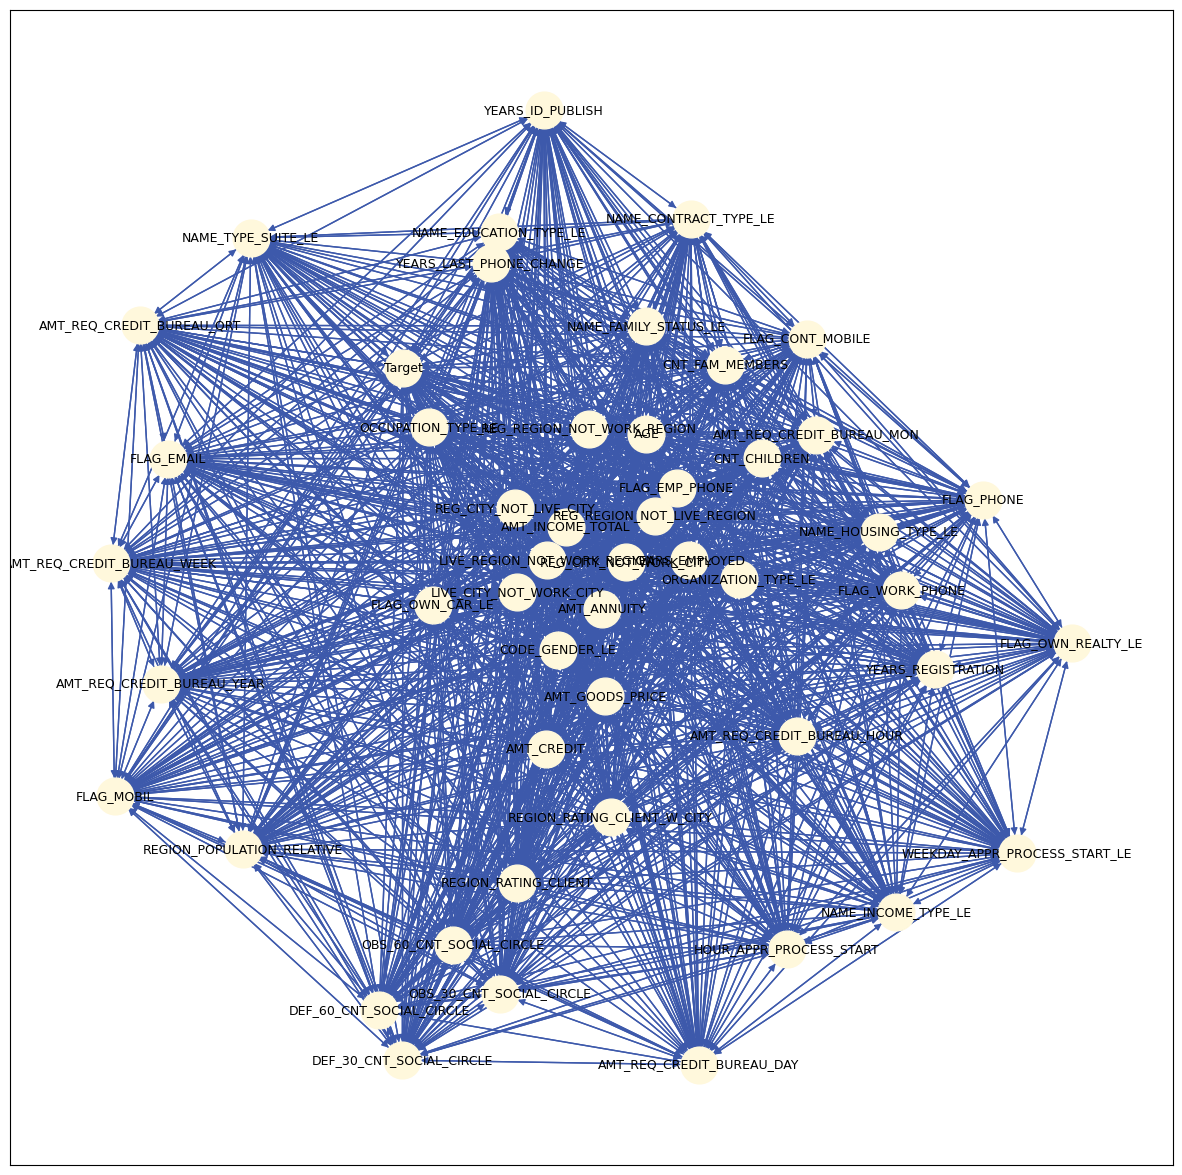

In [77]:
import networkx as nx
from cdt.causality.graph import SAM
import matplotlib.pyplot as plt 
    
#For full dataset, it is getting memory error. 

data = test_df_final
obj = SAM(train_epochs = 400, test_epochs= 400 , batch_size = 300, nruns= 2, verbose = True)

output = obj.predict(data)    

fig=plt.figure(figsize=(15,15))


nx.draw_networkx(output, font_size=9, node_size = 700, node_color = '#FFF8DC',edge_color = '#3D59AB' , font_color='#000000')
plt.show()

In [80]:
g = nx.DiGraph(output)

l = list(g.nodes())
e = list(g.edges())
a = nx.adjacency_matrix(g).todense()

am = pd.DataFrame(a, columns = l)
edges = pd.DataFrame(e)
nodes = pd.DataFrame(l)

# df.insert(loc, column, value)
am.insert(0,column = 'Edge_Start', value = l )
# am.set_index('Edge_Start', inplace = True)

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [81]:
am.rename(columns={'CODE_GENDER_LE':'CODE_GENDER','NAME_CONTRACT_TYPE_LE': 'NAME_CONTRACT_TYPE',
                             'FLAG_OWN_CAR_LE':"FLAG_OWN_CAR" , 'FLAG_OWN_REALTY_LE':'FLAG_OWN_REALTY', 
                              'NAME_TYPE_SUITE_LE':"NAME_TYPE_SUITE",'NAME_INCOME_TYPE_LE':"NAME_INCOME_TYPE",
                              
                              'NAME_EDUCATION_TYPE_LE': "NAME_EDUCATION_TYPE",'NAME_FAMILY_STATUS_LE':"NAME_FAMILY_STATUS",
                              'NAME_HOUSING_TYPE_LE':"NAME_HOUSING_TYPE", 'OCCUPATION_TYPE_LE':"OCCUPATION_TYPE",
                              'WEEKDAY_APPR_PROCESS_START_LE':"WEEKDAY_APPR_PROCESS_START",'ORGANIZATION_TYPE_LE':"ORGANIZATION_TYPE"
                             }, inplace=True)

am.replace({'Edge_Start' : {'CODE_GENDER_LE':'CODE_GENDER','NAME_CONTRACT_TYPE_LE': 'NAME_CONTRACT_TYPE',
                             'FLAG_OWN_CAR_LE':"FLAG_OWN_CAR" , 'FLAG_OWN_REALTY_LE':'FLAG_OWN_REALTY', 
                              'NAME_TYPE_SUITE_LE':"NAME_TYPE_SUITE",'NAME_INCOME_TYPE_LE':"NAME_INCOME_TYPE",
                              
                              'NAME_EDUCATION_TYPE_LE': "NAME_EDUCATION_TYPE",'NAME_FAMILY_STATUS_LE':"NAME_FAMILY_STATUS",
                              'NAME_HOUSING_TYPE_LE':"NAME_HOUSING_TYPE", 'OCCUPATION_TYPE_LE':"OCCUPATION_TYPE",
                              'WEEKDAY_APPR_PROCESS_START_LE':"WEEKDAY_APPR_PROCESS_START",'ORGANIZATION_TYPE_LE':"ORGANIZATION_TYPE"
                             }},inplace=True)

edges.replace({'0' : {'CODE_GENDER_LE':'CODE_GENDER','NAME_CONTRACT_TYPE_LE': 'NAME_CONTRACT_TYPE',
                             'FLAG_OWN_CAR_LE':"FLAG_OWN_CAR" , 'FLAG_OWN_REALTY_LE':'FLAG_OWN_REALTY', 
                              'NAME_TYPE_SUITE_LE':"NAME_TYPE_SUITE",'NAME_INCOME_TYPE_LE':"NAME_INCOME_TYPE",
                              
                              'NAME_EDUCATION_TYPE_LE': "NAME_EDUCATION_TYPE",'NAME_FAMILY_STATUS_LE':"NAME_FAMILY_STATUS",
                              'NAME_HOUSING_TYPE_LE':"NAME_HOUSING_TYPE", 'OCCUPATION_TYPE_LE':"OCCUPATION_TYPE",
                              'WEEKDAY_APPR_PROCESS_START_LE':"WEEKDAY_APPR_PROCESS_START",'ORGANIZATION_TYPE_LE':"ORGANIZATION_TYPE"
                             }},inplace=True)

edges.replace({'1' : {'CODE_GENDER_LE':'CODE_GENDER','NAME_CONTRACT_TYPE_LE': 'NAME_CONTRACT_TYPE',
                             'FLAG_OWN_CAR_LE':"FLAG_OWN_CAR" , 'FLAG_OWN_REALTY_LE':'FLAG_OWN_REALTY', 
                              'NAME_TYPE_SUITE_LE':"NAME_TYPE_SUITE",'NAME_INCOME_TYPE_LE':"NAME_INCOME_TYPE",
                              
                              'NAME_EDUCATION_TYPE_LE': "NAME_EDUCATION_TYPE",'NAME_FAMILY_STATUS_LE':"NAME_FAMILY_STATUS",
                              'NAME_HOUSING_TYPE_LE':"NAME_HOUSING_TYPE", 'OCCUPATION_TYPE_LE':"OCCUPATION_TYPE",
                              'WEEKDAY_APPR_PROCESS_START_LE':"WEEKDAY_APPR_PROCESS_START",'ORGANIZATION_TYPE_LE':"ORGANIZATION_TYPE"
                             }},inplace=True)

nodes.replace({'0' : {'CODE_GENDER_LE':'CODE_GENDER','NAME_CONTRACT_TYPE_LE': 'NAME_CONTRACT_TYPE',
                             'FLAG_OWN_CAR_LE':"FLAG_OWN_CAR" , 'FLAG_OWN_REALTY_LE':'FLAG_OWN_REALTY', 
                              'NAME_TYPE_SUITE_LE':"NAME_TYPE_SUITE",'NAME_INCOME_TYPE_LE':"NAME_INCOME_TYPE",
                              
                              'NAME_EDUCATION_TYPE_LE': "NAME_EDUCATION_TYPE",'NAME_FAMILY_STATUS_LE':"NAME_FAMILY_STATUS",
                              'NAME_HOUSING_TYPE_LE':"NAME_HOUSING_TYPE", 'OCCUPATION_TYPE_LE':"OCCUPATION_TYPE",
                              'WEEKDAY_APPR_PROCESS_START_LE':"WEEKDAY_APPR_PROCESS_START",'ORGANIZATION_TYPE_LE':"ORGANIZATION_TYPE"
                             }},inplace=True)

In [82]:
# edges = pd.DataFrame(e)
# nodes = pd.DataFrame(l)

# edges.to_csv('Edges_TestSet.csv')
# am.to_csv('adjacency_matrix_TestSet.csv')
# nodes.to_csv('nodes_TestSet.csv')

In [83]:
am.head()

,Edge_Start,CNT_CHILDREN,Target,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,...,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,CNT_CHILDREN,0.000000,0.002532,0.002056,0.002571,0.002041,0.002297,0.002419,0.862776,0.039479,...,0.002467,0.003347,0.002112,0.002242,0.003960,0.002323,0.002211,0.002635,0.002412,0.770577
1,Target,0.002348,0.000000,0.002168,0.002421,0.002142,0.002920,0.002188,0.008109,0.005060,...,0.576756,0.002305,0.002376,0.002288,0.042939,0.002039,0.002250,0.002295,0.002285,0.010179
2,AMT_INCOME_TOTAL,0.002249,0.003092,0.000000,0.086879,0.003414,0.002975,0.002548,0.002520,0.006245,...,2.941590,0.002787,0.002125,0.594602,1.736199,0.002509,0.002093,0.002305,0.002240,0.005478
3,AMT_CREDIT,0.002809,0.002604,0.045717,0.000000,0.135844,2.896443,0.002312,0.018438,0.003124,...,0.003440,0.002485,0.002121,0.002741,0.009795,0.002554,0.002020,0.002384,0.003870,0.004036
4,AMT_ANNUITY,0.002077,0.002482,2.901894,0.187040,0.000000,0.010459,0.002155,0.002500,0.053331,...,0.007400,0.002401,0.002211,0.002976,0.005229,0.002247,0.002294,0.002279,0.003195,0.640898


Features affecting Target Variable

In [731]:
#Target Edge and weights

edge_end = am.columns[1:]
target_edge = am["Target"].tolist()
target_edge_sorted = sorted(target_edge, reverse = True)

In [732]:
#Storing Weights in desc order

target_df = pd.DataFrame()
target_df['Weights'] = target_edge_sorted

In [733]:
#Storing Edges with most influence on Target Variable

sorted_target_index = np.argsort(target_edge)[::-1]
print(sorted_target_index)
target_df["Edge"] = edge_end[sorted_target_index]

[44  7 31 40 13 36 18  9 35 19 26 28 10 30 34  6 25  2  8 48 37 39 38 43
 15 46 32 42 12 23 45  0  4 49 29 14 24 47  5 33  3 27 22 21 17 16 20 41
 11  1]


In [734]:
target_df.head(15)

,Weights,Edge
0,2.769351,NAME_EDUCATION_TYPE_LE
1,2.617700,AGE
2,2.493239,YEARS_LAST_PHONE_CHANGE
3,0.061909,FLAG_OWN_CAR_LE
4,0.027187,FLAG_WORK_PHONE
5,0.022868,AMT_REQ_CREDIT_BUREAU_QRT
6,0.012867,REGION_RATING_CLIENT
7,0.012859,YEARS_REGISTRATION
8,0.011230,AMT_REQ_CREDIT_BUREAU_MON
9,0.010480,REGION_RATING_CLIENT_W_CITY


In [735]:
import plotly.express as px

fig = px.line(target_df.head(15), y="Weights", x = "Edge",markers = True, title = "Features Affecting Target")
# fig.update_traces(textposition="top left")
fig.show()

In [736]:
display(target_df[target_df["Edge"] == "AGE"])
display(target_df[target_df["Edge"] == "CODE_GENDER_LE"])
display(target_df[target_df["Edge"] == "NAME_FAMILY_STATUS_LE"])

,Weights,Edge
1,2.6177,AGE


,Weights,Edge
21,0.004519,CODE_GENDER_LE


,Weights,Edge
30,0.002745,NAME_FAMILY_STATUS_LE


Indirect Effect of Protected attributes

Who is CODE_GENDER_LE affecting?

In [737]:
#Target Edge and weights
edge_end = am.columns[1:]

ind = am[am["Edge_Start"] == "CODE_GENDER_LE"].index

# Extract the row of CODE GENDER as it will give all the weights of the edges starting from CODE_GENDER
edge_weights = am.iloc[ind, 1:].values.flatten().tolist()
edge_weights_sorted = sorted(edge_weights, reverse = True)

#Storing Weights in desc order
CODE_GENDER_LE_df = pd.DataFrame()
CODE_GENDER_LE_df['Weights'] = edge_weights_sorted

#Storing Edges with most influence on EXT_SOURCE_2
sorted_weight_index = np.argsort(edge_weights)[::-1]
# print(sorted_weight_index)
CODE_GENDER_LE_df["Edge"] = edge_end[sorted_weight_index]

CODE_GENDER_LE_df.head(15)

,Weights,Edge
0,2.813249,FLAG_OWN_CAR_LE
1,0.078615,OCCUPATION_TYPE_LE
2,0.060989,ORGANIZATION_TYPE_LE
3,0.007355,OBS_30_CNT_SOCIAL_CIRCLE
4,0.005149,AGE
5,0.004519,Target
6,0.003706,FLAG_EMP_PHONE
7,0.003451,AMT_INCOME_TOTAL
8,0.003333,FLAG_PHONE
9,0.002976,DEF_60_CNT_SOCIAL_CIRCLE


In [227]:
display(target_df[target_df["Edge"] == "FLAG_OWN_CAR_LE"])
display(target_df[target_df["Edge"] == "OCCUPATION_TYPE_LE"])
display(target_df[target_df["Edge"] == "ORGANIZATION_TYPE_LE"])
display(target_df[target_df["Edge"] == "OBS_30_CNT_SOCIAL_CIRCLE"])
display(target_df[target_df["Edge"] == "AGE"])

,Weights,Edge
3,0.061909,FLAG_OWN_CAR_LE


,Weights,Edge
37,0.002601,OCCUPATION_TYPE_LE


,Weights,Edge
33,0.002696,ORGANIZATION_TYPE_LE


,Weights,Edge
41,0.002433,OBS_30_CNT_SOCIAL_CIRCLE


,Weights,Edge
1,2.6177,AGE


Who is NAME_FAMILY_STATUS_LE affecting?

In [228]:
#Target Edge and weights
edge_end = am.columns[1:]

ind = am[am["Edge_Start"] == "NAME_FAMILY_STATUS_LE"].index
print(am.iloc[ind, 0].values)

# Extract the row of CODE GENDER as it will give all the weights of the edges starting from CODE_GENDER
edge_weights = am.iloc[ind, 1:].values.flatten().tolist()
edge_weights_sorted = sorted(edge_weights, reverse = True)

#Storing Weights in desc order
NAME_FAMILY_STATUS_LE_df = pd.DataFrame()
NAME_FAMILY_STATUS_LE_df['Weights'] = edge_weights_sorted

#Storing Edges with most influence on EXT_SOURCE_2
sorted_weight_index = np.argsort(edge_weights)[::-1]
# print(sorted_weight_index)
NAME_FAMILY_STATUS_LE_df["Edge"] = edge_end[sorted_weight_index]

NAME_FAMILY_STATUS_LE_df.head(15)

['NAME_FAMILY_STATUS_LE']


,Weights,Edge
0,1.475027,CNT_FAM_MEMBERS
1,0.012692,CNT_CHILDREN
2,0.004821,FLAG_OWN_REALTY_LE
3,0.003770,OBS_60_CNT_SOCIAL_CIRCLE
4,0.003760,FLAG_OWN_CAR_LE
5,0.002986,LIVE_REGION_NOT_WORK_REGION
6,0.002905,REG_REGION_NOT_WORK_REGION
7,0.002843,AMT_CREDIT
8,0.002830,HOUR_APPR_PROCESS_START
9,0.002812,REG_CITY_NOT_LIVE_CITY


In [229]:
display(target_df[target_df["Edge"] == "CNT_FAM_MEMBERS"])
display(target_df[target_df["Edge"] == "CNT_CHILDREN"])
display(target_df[target_df["Edge"] == "FLAG_OWN_REALTY_LE"])
display(target_df[target_df["Edge"] == "OBS_60_CNT_SOCIAL_CIRCLE"])
display(target_df[target_df["Edge"] == "FLAG_OWN_CAR_LE"])

,Weights,Edge
44,0.002298,CNT_FAM_MEMBERS


,Weights,Edge
31,0.002737,CNT_CHILDREN


,Weights,Edge
47,0.002192,FLAG_OWN_REALTY_LE


,Weights,Edge
34,0.002672,OBS_60_CNT_SOCIAL_CIRCLE


,Weights,Edge
3,0.061909,FLAG_OWN_CAR_LE


In [741]:
# am["CNT_CHILDREN"]

Fairness Metrics

In [230]:
# pip install fairlearn

Trainning Data

How label encoded?

In [231]:
display(train_df_new["CODE_GENDER"].unique())
display(train_df_new["CODE_GENDER_LE"].unique())
display(train_df_new["NAME_FAMILY_STATUS"].unique())
display(train_df_new["NAME_FAMILY_STATUS_LE"].unique())

array(['M', 'F'], dtype=object)

array([1, 0])

array(['Single / not married', 'Married', 'Widow', 'Civil marriage',
       'Separated'], dtype=object)

array([3, 1, 4, 0, 2])

In [233]:
display(train_df_new[["CODE_GENDER","CODE_GENDER_LE"]])

# 0 - Female, 
# 1 - Male

display(train_df_new[["NAME_FAMILY_STATUS","NAME_FAMILY_STATUS_LE"]])

# array(['Single / not married', 'Married', 'Widow', 'Civil marriage',
#        'Separated'], dtype=object)
# array([3, 1, 4, 0, 2])

# 0 - Civil Marriage
# 1 - Married
# 2 - Seperated
# 3 - Single
# 4 - Widow

,CODE_GENDER,CODE_GENDER_LE
0,M,1
1,F,0
2,F,0
3,M,1
4,F,0
...,...,...
99996,M,1
99997,F,0
99998,F,0
99999,F,0


,NAME_FAMILY_STATUS,NAME_FAMILY_STATUS_LE
0,Single / not married,3
1,Married,1
2,Married,1
3,Single / not married,3
4,Single / not married,3
...,...,...
99996,Married,1
99997,Married,1
99998,Widow,4
99999,Separated,2


This train_df_new was converted to train_df_final by dropping columns and then train_df_final was split into X and Y. 

The fairness metrics will be calcualted on the prediction of our test dataset

In [558]:
# drop_xna_index = X[X["CODE_GENDER_LE"] == 2].index
# drop_xna_index

In [559]:
X_fairness = test_df_final.loc[:, test_df_final.columns != 'Target']
y_fairness = test_df_final.loc[:, test_df_final.columns == 'Target']

# drop_xna_index = X[X["CODE_GENDER_LE"] == 2].index

# X_fairness.drop(index = drop_xna_index, inplace = True)
# y_fairness.drop(index = drop_xna_index, inplace = True)

In [560]:
# y_fairness

CODE_GENDER

In [561]:
y_pred = model.predict(X_fairness)
sensitive_features_code_gender =X_fairness["CODE_GENDER_LE"]
sensitive_features_code_gender

C:\Users\user\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



0      0
1      1
2      1
3      0
4      1
      ..
995    1
996    1
997    1
998    0
999    0
Name: CODE_GENDER_LE, Length: 1000, dtype: int32

In [256]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate
sr = MetricFrame(metrics=selection_rate, y_true=y_fairness, y_pred=y_pred, sensitive_features=sensitive_features_code_gender)
# display(sr.overall)
display(sr.by_group)

CODE_GENDER_LE
0    0.279070
1    0.380282
Name: selection_rate, dtype: float64

In [257]:
from fairlearn.metrics import demographic_parity_difference
from fairlearn.metrics import demographic_parity_ratio

dp = demographic_parity_difference(y_true=y_fairness, y_pred=y_pred, sensitive_features=sensitive_features_code_gender, method='between_groups')
dp_ratio = demographic_parity_ratio(y_true=y_fairness, y_pred=y_pred, sensitive_features=sensitive_features_code_gender, method='between_groups')

print("The dp difference for Gender is ", dp)
print("The dp ratio for Gender is ", dp_ratio)

The dp difference for Gender is  0.1012119226989846
The dp ratio for Gender is  0.7338501291989664


NAME_FAMILY_STATUS

In [258]:
y_pred = model.predict(X_fairness)

sensitive_features_family_status =X_fairness["NAME_FAMILY_STATUS_LE"]
# sensitive_features_code_gender

C:\Users\user\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [262]:
sr = MetricFrame(metrics=selection_rate, y_true=y_fairness, y_pred=y_pred, sensitive_features=sensitive_features_family_status)
# display(sr.overall)
display(sr.by_group)

NAME_FAMILY_STATUS_LE
0    0.405941
1    0.294469
2    0.313725
3    0.379845
4    0.240000
Name: selection_rate, dtype: float64

In [263]:
dp = demographic_parity_difference(y_true=y_fairness, y_pred=y_pred, sensitive_features=sensitive_features_family_status, method='between_groups')
dp_ratio = demographic_parity_ratio(y_true=y_fairness, y_pred=y_pred, sensitive_features=sensitive_features_family_status, method='between_groups')

print("The dp difference for Family Status is ", dp)
print("The dp ratio for Family Status is ", dp_ratio)

The dp difference for Family Status is  0.16594059405940598
The dp ratio for Family Status is  0.5912195121951219


DAYS_BIRTH

In [266]:
X_fairness["AGE"]

0      53.0
1      49.0
2      55.0
3      38.0
4      36.0
       ... 
995    36.0
996    31.0
997    30.0
998    31.0
999    42.0
Name: AGE, Length: 1000, dtype: float64

In [268]:
y_pred = model.predict(X_fairness)
sensitive_features_age = X_fairness["AGE"]

In [269]:
sr = MetricFrame(metrics=selection_rate, y_true=y_fairness, y_pred=y_pred, sensitive_features=sensitive_features_age)
# display(sr.overall)

AGE
21.0    0.000000
22.0    1.000000
23.0    0.500000
24.0    0.526316
25.0    0.500000
26.0    0.470588
27.0    0.333333
28.0    0.320000
29.0    0.378378
30.0    0.607143
31.0    0.545455
32.0    0.321429
33.0    0.432432
34.0    0.470588
35.0    0.421053
36.0    0.576923
37.0    0.457143
38.0    0.272727
39.0    0.240000
40.0    0.320000
41.0    0.210526
42.0    0.583333
43.0    0.259259
44.0    0.230769
45.0    0.045455
46.0    0.464286
47.0    0.280000
48.0    0.291667
49.0    0.157895
50.0    0.260870
51.0    0.187500
52.0    0.250000
53.0    0.045455
54.0    0.280000
55.0    0.277778
56.0    0.333333
57.0    0.105263
58.0    0.263158
59.0    0.160000
60.0    0.230769
61.0    0.230769
62.0    0.166667
63.0    0.111111
64.0    0.117647
65.0    0.000000
66.0    0.000000
67.0    0.000000
68.0    0.000000
Name: selection_rate, dtype: float64

In [270]:
dp = demographic_parity_difference(y_true=y_fairness, y_pred=y_pred, sensitive_features=sensitive_features_age, method='between_groups')
dp_ratio = demographic_parity_ratio(y_true=y_fairness, y_pred=y_pred, sensitive_features=sensitive_features_age, method='between_groups')

print("The dp difference for Age is ", dp)
print("The dp ratio for Age is ", dp_ratio)

The dp difference for Age is  1.0
The dp ratio for Age is  0.0


This is not the ideal difference or ratio, as Age is a countinous variable, hence we would need to perform binning. As we can see our age ranges roughly from 20 -70, we would perform equal frequency binning

General Notion Binning

Ranges from 21 to 68

1. Facial Age Group Classification
Babies : 0-2 
Children : 3-16
Young Adults : 17-30
Middle Age Adults : 31-45
Old Adults : 45+

2. Emerging adult reactions to labeling regarding age-group differences in narcissism and entitlement
Adolescents :  12 - 17
Young Adults : 18-25
Adults: 26-40
Middle Age Adults : 41 - 60
Older Adults: 60+

2 method is most recent and widely used. When we examine and relate to our dataset the values are well distributed in bins for the second method.


In [704]:
len(sr.by_group)

48

In [716]:
young_adults = sr.by_group.loc[:25]
adults = sr.by_group.loc[26:40]
middle_age_adults = sr.by_group.loc[41:60]
older_adults = sr.by_group.loc[61:]

young_adults_risk_rate = round(np.mean(young_adults),2)
adults_risk_rate = round(np.mean(adults),2)
middle_age_adults_risk_rate = round(np.mean(middle_age_adults),2)
older_adults_risk_rate = round(np.mean(older_adults),2)


age_risk_groups= {"Young Adults (18-25)" : 100*young_adults_risk_rate,"Adults (26-40)" : 100*adults_risk_rate, 
                  "Middle Age Adults (41 - 60)": 100*middle_age_adults_risk_rate, "Older Adults (60+)":100*older_adults_risk_rate}

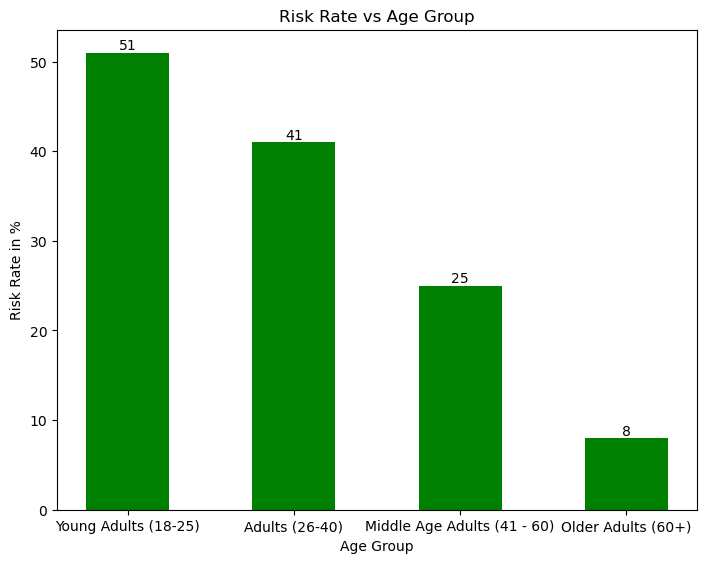

In [727]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(age_risk_groups.keys(),age_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs Age Group")
plt.xlabel('Age Group')
plt.ylabel('Risk Rate in %')
plt.show()

In [722]:
print("The dp difference for Age is ", max(age_risk_groups.values()) - min(age_risk_groups.values()))
print("The dp ratio for Age is ", round(min(age_risk_groups.values()) / max(age_risk_groups.values()),2))

The dp difference for Age is  43.0
The dp ratio for Age is  0.16


Individual Fairness

In [565]:
from aif360.sklearn.metrics import consistency_score
cs = consistency_score(X_fairness, y_fairness)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [566]:
print("Consistency Score for our model on this dataset is: ", round(cs,2))

Consistency Score for our model on this dataset is:  0.72


In [567]:
test_df

,SK_ID_CURR,Predicted_Result,Prediction_Confidence_Accepted,Prediction_Confidence_Rejected,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Accepted,83.560,16.440,Cash loans,F,N,Y,0,135000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Accepted,57.415,42.585,Cash loans,M,N,Y,0,99000.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Accepted,98.342,1.658,Cash loans,M,Y,Y,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Accepted,71.770,28.230,Cash loans,F,N,Y,2,315000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Rejected,48.065,51.935,Cash loans,M,Y,N,1,180000.0,...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106851,Accepted,92.030,7.970,Cash loans,M,Y,Y,0,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
996,106852,Accepted,83.939,16.061,Cash loans,M,N,Y,2,225000.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
997,106853,Rejected,26.817,73.183,Cash loans,M,Y,N,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
998,106854,Rejected,41.689,58.311,Cash loans,F,N,Y,0,202500.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0


In [574]:
# test_df.replace({'FLAG_MOBIL' : { "N" :'No', "Y" : 'Yes'}},inplace=True)

# test_df.replace({'FLAG_EMP_PHONE' : { "N" :'No', "Y" : 'Yes'}},inplace=True)

# test_df.replace({'FLAG_WORK_PHONE' : { "N" :'No', "Y" : 'Yes'}},inplace=True)

# test_df.replace({'FLAG_CONT_MOBILE' : { "N" :'No', "Y" : 'Yes'}},inplace=True)

# test_df.replace({'FLAG_PHONE' : {"N" :'No', "Y" : 'Yes'}},inplace=True)

# test_df.replace({'FLAG_EMAIL' : { "N" :'No', "Y" : 'Yes'}},inplace=True)

# test_df.replace({'FLAG_OWN_CAR' : { "N" :'No', "Y" : 'Yes'}},inplace=True)

# test_df.replace({'FLAG_OWN_REALTY' : { "N" :'No', "Y" : 'Yes'}},inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_22944\1196988966.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_22944\1196988966.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_22944\1196988966.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [570]:
test_df.replace({'NAME_CONTRACT_TYPE' : { 'Cash loans' :'Fixed', 'Revolving loans' : 'Not Fixed'}},inplace=True)

test_df.replace({'FLAG_MOBIL' : { 0 :'No', 1 : 'Yes'}},inplace=True)

test_df.replace({'FLAG_EMP_PHONE' : { 0 :'No', 1 : 'Yes'}},inplace=True)

test_df.replace({'FLAG_WORK_PHONE' : { 0 :'No', 1 : 'Yes'}},inplace=True)

test_df.replace({'FLAG_CONT_MOBILE' : { 0 :'No', 1 : 'Yes'}},inplace=True)

test_df.replace({'FLAG_PHONE' : { 0 :'No', 1 : 'Yes'}},inplace=True)

test_df.replace({'FLAG_EMAIL' : { 0 :'No', 1 : 'Yes'}},inplace=True)



# test_df[["REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", 
#          "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY"]]

test_df.replace({'REG_REGION_NOT_LIVE_REGION' : { 0 :'Same', 1 : 'Different'}},inplace=True)

test_df.replace({'REG_REGION_NOT_WORK_REGION' : { 0 :'Same', 1 : 'Different'}},inplace=True)

test_df.replace({'LIVE_REGION_NOT_WORK_REGION' : { 0 :'Same', 1 : 'Different'}},inplace=True)

test_df.replace({'REG_CITY_NOT_LIVE_CITY' : { 0 :'Same', 1 : 'Different'}},inplace=True)

test_df.replace({'REG_CITY_NOT_WORK_CITY' : { 0 :'Same', 1 : 'Different'}},inplace=True)

test_df.replace({'LIVE_CITY_NOT_WORK_CITY' : { 0 :'Same', 1 : 'Different'}},inplace=True)

test_df.replace({'CODE_GENDER' : { "F" :'Female', "M" :'Male'}},inplace=True)

test_df.replace({'YEARS_EMPLOYED' : { -1001 :np.nan}},inplace=True)

test_df

C:\Users\user\AppData\Local\Temp\ipykernel_22944\2651702036.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_22944\2651702036.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_22944\2651702036.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,SK_ID_CURR,Predicted_Result,Prediction_Confidence_Accepted,Prediction_Confidence_Rejected,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Accepted,83.560,16.440,Fixed,F,N,Y,0,135000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Accepted,57.415,42.585,Fixed,M,N,Y,0,99000.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Accepted,98.342,1.658,Fixed,M,Y,Y,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Accepted,71.770,28.230,Fixed,F,N,Y,2,315000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Rejected,48.065,51.935,Fixed,M,Y,N,1,180000.0,...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106851,Accepted,92.030,7.970,Fixed,M,Y,Y,0,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
996,106852,Accepted,83.939,16.061,Fixed,M,N,Y,2,225000.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
997,106853,Rejected,26.817,73.183,Fixed,M,Y,N,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
998,106854,Rejected,41.689,58.311,Fixed,F,N,Y,0,202500.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0


In [586]:
df = test_df.select_dtypes(exclude=["number"])
for col in df:
    print(df[col].unique())

['Accepted' 'Rejected']
['Fixed' 'Not Fixed']
['Female' 'Male']
['No' 'Yes']
['Yes' 'No']
['Unaccompanied' nan 'Family' 'Spouse, partner' 'Group of people'
 'Other_B' 'Children' 'Other_A']
['Working' 'State servant' 'Pensioner' 'Commercial associate']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary']
['Married' 'Single / not married' 'Civil marriage' 'Widow' 'Separated']
['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
['Yes']
['Yes' 'No']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['Yes' 'No']
[nan 'Low-skill Laborers' 'Drivers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Laborers' 'Managers' 'Accountants' 'Medicine staff'
 'Security staff' 'Private service staff' 'Secretaries' 'Cleaning staff'
 'Cooking staff' 'HR staff' 'Waiters/barmen staff' 'Realty agents'
 'IT staff']
['TUESDAY' 'FRIDAY' 'MONDAY' 'WEDNESDAY' 'THURSDAY' 'SATURDAY' 'SUNDAY']
['Same' 'Different']
['Same'

In [598]:
test_df.to_csv("Model_Predictions_161122.csv")

Random Analysations

In [144]:
test_df

,SK_ID_CURR,Predicted_Result,Prediction_Confidence_Accepted,Prediction_Confidence_Rejected,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Accepted,92.331,7.669,Cash loans,F,N,Y,0,135000.0,...,0.0,0.0,0.0,-1740.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Accepted,50.537,49.463,Cash loans,M,N,Y,0,99000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Accepted,96.698,3.302,Cash loans,M,Y,Y,0,202500.0,...,0.0,0.0,0.0,-856.0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Accepted,67.179,32.821,Cash loans,F,N,Y,2,315000.0,...,0.0,0.0,0.0,-1805.0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Accepted,80.075,19.925,Cash loans,M,Y,N,1,180000.0,...,0.0,0.0,0.0,-821.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106851,Accepted,95.260,4.740,Cash loans,M,Y,Y,0,297000.0,...,0.0,0.0,0.0,-7.0,0.0,0.0,0.0,0.0,1.0,2.0
996,106852,Accepted,68.566,31.434,Cash loans,M,N,Y,2,225000.0,...,0.0,3.0,0.0,-389.0,0.0,0.0,0.0,0.0,0.0,3.0
997,106853,Accepted,53.958,46.042,Cash loans,M,Y,N,0,202500.0,...,0.0,0.0,0.0,-592.0,0.0,0.0,0.0,0.0,1.0,1.0
998,106854,Rejected,46.949,53.051,Cash loans,F,N,Y,0,202500.0,...,0.0,0.0,0.0,-1020.0,0.0,0.0,0.0,0.0,1.0,3.0


In [267]:
# edges.to_csv('Edges_TestSet.csv')
# am.to_csv('adjacency_matrix_TestSet.csv')
# nodes.to_csv('nodes_TestSet.csv')

In [ ]:
# from cdt.causality.graph import CGNN

 
# data = test_df_final

# obj = CGNN(train_epochs=400, test_epochs= 400 , batch_size = 300, nruns= 1, verbose = True)

# output = obj.predict(data) 


# fig=plt.figure(figsize=(10,8))
# # nx.draw_networkx(output)
# # nx.draw(output)


# nx.draw_networkx(output, font_size=9, node_size = 700, node_color = '#FFF8DC',edge_color = '#3D59AB' , font_color='#000000')
# plt.show()

In [797]:
# # HomeCredit_columns_description = pd.read_csv('HomeCredit_columns_description.csv', encoding = "ISO-8859-1")
# # display(HomeCredit_columns_description)
# column_description = HomeCredit_columns_description[['Row',"Description"]]
# lista = []
# for i in range(len(inconsistent_features)):
#     a = column_description[HomeCredit_columns_description["Row"] == inconsistent_features[i]].values.flatten()
#     lista.append(a)

# df = pd.DataFrame(lista)
# df.to_html('inconsistent columns.html')

In [798]:
# #Dropping the features with more than 25% missing values
# workout_data.drop(columns = inconsistent_features,inplace = True)

# print("The dropped features are ", inconsistent_features)
# print("The resultant shape of our dataset is ",workout_data.shape)

In [746]:
# variance = application_train.var()
# len(variance)
# #saving the names of variables having variance more than a threshold value
# columns = application_train.columns
# variable = [ ]

# for i in range(0,len(variance)):
#     if variance[i]>=0.006: #setting the threshold as 1%
#         variable.append(columns[i])